<a href="https://colab.research.google.com/github/pgordin/OptDisc2025/blob/main/ProjektMK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skojarzenia w grafach dwudzielnych
Mateusz Kowalczyk 258087

## Importowanie pakietów

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import random, seed
from copy import deepcopy
from queue import PriorityQueue
from collections import deque

## Wczytajmy najpierw gotowe funkcje z zajęć

In [ ]:
def print_matrix(vertices, matrix):
  n=len(matrix)
  if (vertices is not None) and (len(vertices)==n):
    vv=vertices
  else:
    vv=range(1,n+1)
  for i in range(n):
    print(vv[i], ":", end="")
    for j in range(n):
      if matrix[i,j]:
        print(" ", vv[j], end="")
    print("")

In [ ]:
def print_graph(graph):
  for v in graph:
    print(v, ":", end="")
    for u in graph[v]:
      print(" ", u, end="")
    print("")

In [ ]:
def klucz_od_wartości(s, value):
  for klucz, wartosc in s.items():
    if wartosc == value:
      return klucz
  return None

##Wczytajmy clasę

In [ ]:
class Graph:
    def __init__(self, graph=None):
        if graph is None:
            graph = {}
        self.graph = graph

    # dict initializer
    @classmethod
    def from_dict(cls, graph):
        return cls(graph)

    # array initializer
    @classmethod
    def from_matrix(cls, matrix, vertices = None):
        if (vertices is None) or (len(vertices) != len(matrix)):
            vertices = [*range(1, len(matrix) + 1)]
        return cls.from_dict(cls._matrix_to_dict(matrix, vertices))

    # two private methods matrix <-> dictionaries
    def _matrix_to_dict(matrix, vertices: list) -> dict:
        """
        Converts a graph given as an adjacency matrix to a graph in dict form.
        """
        res_dict = {}
        for i, v in enumerate(vertices):
            neighbours = [vertices[j] for j, edge in enumerate(matrix[i]) if edge]
            res_dict[v] = neighbours
        return res_dict

    def _dict_to_matrix(self, _dict: dict) -> np.array:
        """
        Converts a graph in dict form to its adjacency matrix.
        """
        n = len(_dict)
        vertices = [*_dict.keys()]
        matrix = np.zeros(shape = (n, n), dtype=int)
        for u,v in [
            (vertices.index(u), vertices.index(v))
            for u, row in _dict.items() for v in row
        ]:
            matrix[u][v] += 1
        return matrix

    def vertices(self) -> list:
        """
        Returns list of vertices of the graph.
        """
        return [*self.graph.keys()]

    def matrix(self) -> np.array:
        """
        Returns the adjacency matrix of the graph.
        """
        return self._dict_to_matrix(self.graph)

    # redefinition of print for objects of class Graph
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}"
            res += "\n"
        return res

    # The following is for free thanks to the above
    def to_neighbourlist(self, filename: str):
        """
        Saves a graphs to a text file as a neighbour dict.\n
        Filename is a file path.
        """
        file = open(filename, "w")  # open textfile for writing
        file.write(str(self))
        file.close()

    # Modyfying graphs
    def add_vertex(self, vertex):
        """
        Adds a new vertex to the graph.
        """
        if vertex not in self.graph:
            self.graph[vertex] = []

    def del_vertex(self, vertex):
        """
        Removes a vertex from the graph.
        """
        if vertex in self.graph:
            self.graph.pop(vertex)
            for u in self.graph:
                if vertex in self.graph[u]:
                    self.graph[u].remove(vertex)

    def add_arc(self, arc):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        u, v = arc
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)

    def add_edge(self, edge: list):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        if u == v:
            raise ValueError("Loops are not allowed!")
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)
        if u not in self.graph[v]:
            self.graph[v].append(u)

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = Graph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) >= 2:             # at least two words, first two are the edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
        file.close()
        return graph

    @staticmethod
    def random_graph(n: int, p: float):
        """
        Creates a random graph in G(n, p) model.
        """
        rand_graph = Graph()
        for i in range(1, n + 1):
            rand_graph.add_vertex(i)
            for j in range(1, i):
                if random() < p:
                    rand_graph.add_edge([i, j])
        return rand_graph

    @staticmethod
    def cycle(n: int):
        """
        Creates a cycle C_n on n vertices
        """
        cycle = Graph()
        for i in range(n-1):
          cycle.add_edge([i+1, i+2])
        cycle.add_edge([1, n])
        return cycle

    def draw(self):
      """
      Draws the graph using networkx.
      """
      G = nx.Graph()
      for u in self.graph:
        for v in self.graph[u]:
          G.add_edge(u, v)
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True)
      plt.show()

    def Prufer(self):
      """
      Returns the Prufer code of a tree.
      It is necessary that the graph is a tree (it is not checked).
      Result is given as a string (empty for trees on 1 or 2 vertices).
      """
      tr = deepcopy(self.graph)   # copy of a tree, as we destroy it
      code = ""
      for i in range(len(self.graph) - 2):
        for x in sorted(tr):
          if len(tr[x]) == 1:   # least leaf
            break
        v = tr[x][0]            # the unique neighbour of x
        code = code + f"{v} "
        tr[v].remove(x)         # remove x from neighbours of v
        tr.pop(x)               # remove x from the tree
      return code.strip()

    @staticmethod
    def tree_from_Prufer(code: str):
        """
        Creating a tree from a Prufer code.
        """
        tree = Graph()
        clist = [int(x) for x in code.strip().split()]   # code as a list of numbers
        n = len(clist) + 2                  # number of vertices
        vert = [*range(1, n+1)]             # list of numbers 1..n
        for v in vert:
          tree.add_vertex(v)
        for i in range(n-2):
          for x in vert:
            if not x in clist:    # x - least leaf
              break
          v = clist.pop(0)    # remove the first element from the code - the neighbour of x
          tree.add_edge((x, v))
          vert.remove(x)
        tree.add_edge(vert)
        return tree

    def connected_components(self):
      """
      Szuka spójnych skłądowych w (nieskierowanym) grafie.
      Zwraca listę zbiorów wierzchołków.
      Uwaga: zerowy element listy zawiera wszystkie wierzchołki grafu
      """
      def DFS(u):
        """
        Przechodzenie w głąb - metoda wewnętrzna
        """
        for w in self.graph[u]:
          if w not in VT[0]:    # w jeszcze nieodwiedzony
            VT[0].add(w)        # już odwiedzony
            VT[-1].add(w)       # w ostatniej (aktualnej) spójnej składowej
            DFS(w)
      """
      VT - lista zbiorów wierzchołków (drzew DFS).
      VT[0] - docelowo lista wszystkich wierzchołków w grafie.
      """
      VT = [set([])]
      for v in self.graph:
        if not v in VT[0]:  # v - nieodwiedzony
          VT[0].add(v)      # już odwiedzony
          VT.append(set([v])) # zalążek nowej spójnej składowej
          DFS(v)
      return VT

    def connected_components_graphs(self):
      """
      Zwraca listę spójnych składowych (jako grafów).
      """
      components = self.connected_components()  # lista zbiorów wierzchołków
      component_graphs = []                     # zalążek listy grafów
      for component in components[1:]:
        subgraph = Graph()
        for vertex in component:
          subgraph.graph[vertex] = self.graph[vertex].copy()
        component_graphs.append(subgraph)
      return component_graphs

    def distance(self, v):
      """
      Oblicza odległości z wierzhołka v do każdego osiąglanego wierzchołka w grafie.
      Używa BFS. Wynik podany jako słownik (indeksowany etykietami wierzchołków).
      """
      dist = {v: 0}   # zalążek słownika
      queue = [v]
      while len(queue) > 0:
        u = queue.pop(0)
        for w in self.graph[u]:
          if not w in dist:
            dist[w] = dist[u] + 1
            queue.append(w)
      return dist

    @staticmethod
    def random_bipartite_graph_nk(n: int,k: int, p: float):
        rand_graph = Graph()

        for i in range(1, n + k + 1):
          rand_graph.add_vertex(i)
        reds=[*range(1, n+1)]
        blacks=[*range(n+1, n+k+1)]
        for i in reds:
          for j in blacks:
            if random() < p:
              rand_graph.add_edge([i, j])
        return rand_graph


    def bipartite_matching(self, X, matching):
      """
      Funkcja bierze graph oraz  listę wierzchołków X.
      Funkcja zwraca skojarzenia w postaci słownika.
      """
      Mx=set(matching.keys())
      U=X.copy()
      U = list(filter(lambda x: x not in Mx, U))
      a=1
      while a!=0:
        S=U.copy()
        a=0
        T=[]
        pop={}
        kol=deque()
        for i in U:
          kol.append(i)
        while len(kol)!=0:
          u=kol.popleft()
          for v in self.graph[u]:
            if v not in T:
              if v in matching.values():
                pop[v]=u
                x=klucz_od_wartości(matching,v)
                kol.appendleft(x)
                S.append(x)
                T.append(v)
              else:
                x=u
                while x in matching.keys():
                  y=matching[x]
                  matching[x]=v
                  x=pop[y]
                  v=y
                matching[x]=v
                U.remove(x)
                a=1
                break
          if a==1:
            kol.clear()
        Sset=set(S)
        Q=list(filter(lambda x: x not in Sset, X))+T
      return matching, Q





#Pokaz działania

In [ ]:
np.random.seed(2025)

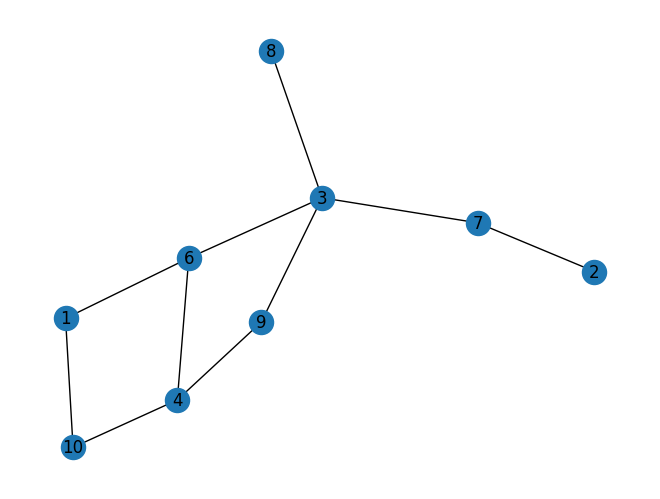

In [ ]:
graph=Graph.random_bipartite_graph_nk(5,5,0.5)
graph.draw()

In [ ]:
X=[1,2,3,4,5]
matching={3:7, 4:10}
match, Q =graph.bipartite_matching(X,matching)
print(match)
print(Q)

{3: 8, 4: 10, 1: 6, 2: 7}
[1, 2, 3, 4]


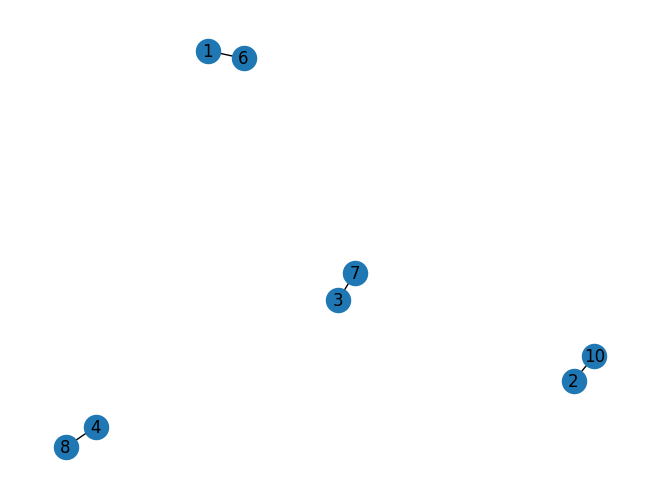

In [ ]:
mgraph=Graph()
for u, v in match.items():
  mgraph.add_edge([u, v])
mgraph.draw()